<a href="https://colab.research.google.com/github/guptapawan227/Capstone_AIML/blob/Ashish/Capstone_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounting Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Importing Libraries

In [2]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import time, os, sys, itertools, re 
from PIL import Image
import warnings, pickle, string
from dateutil import parser
%matplotlib inline

# Data Visualization
import cufflinks as cf
import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot

Reading the data from excel 

In [3]:
data=pd.read_excel('/content/drive/MyDrive/Capstone/input_data.xlsx')
#data=pd.read_excel('input_data.xlsx')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Short description  8492 non-null   object
 1   Description        8499 non-null   object
 2   Caller             8500 non-null   object
 3   Assignment group   8500 non-null   object
dtypes: object(4)
memory usage: 265.8+ KB


Exploratory Data Analysis

In [4]:
data.head()

Short description  ... Assignment group
0                    login issue  ...            GRP_0
1                        outlook  ...            GRP_0
2             cant log in to vpn  ...            GRP_0
3  unable to access hr_tool page  ...            GRP_0
4                   skype error   ...            GRP_0

[5 rows x 4 columns]

In [5]:
assignment_group_count=data['Assignment group'].value_counts()
assignment_group_count.describe()

count      74.000000
mean      114.864865
std       465.747516
min         1.000000
25%         5.250000
50%        26.000000
75%        84.000000
max      3976.000000
Name: Assignment group, dtype: float64

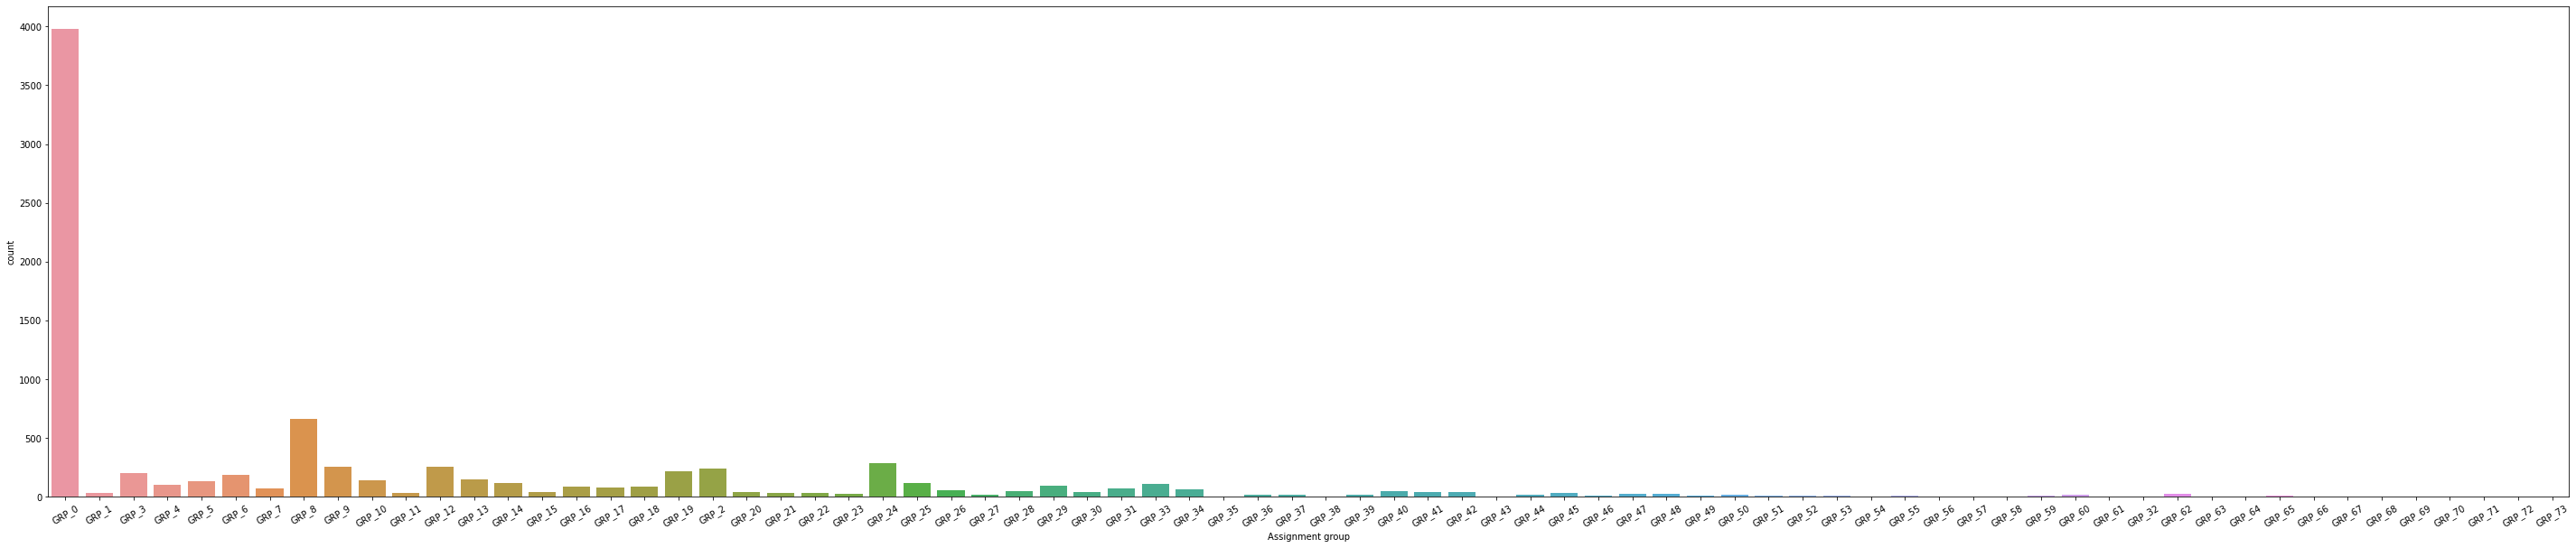

In [6]:
plt.subplots(figsize=(50,10))
ax=sns.countplot(x='Assignment group', data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
plt.tight_layout
plt.show()


Find groups which are having a count less than 10 and assigning them to a new group

In [7]:
COUNT = 10
groups = data.groupby(["Assignment group"])
low_count_group=[]
for group in data["Assignment group"].unique():
  if(groups.get_group(group).shape[0] < COUNT):
    low_count_group.append(group)
print(f"Following are the groups with a count lesser than {COUNT}:\n{low_count_group}\n")

Following are the groups with a count lesser than 10:
['GRP_35', 'GRP_38', 'GRP_43', 'GRP_46', 'GRP_49', 'GRP_51', 'GRP_52', 'GRP_54', 'GRP_55', 'GRP_56', 'GRP_57', 'GRP_58', 'GRP_59', 'GRP_61', 'GRP_32', 'GRP_63', 'GRP_64', 'GRP_66', 'GRP_67', 'GRP_68', 'GRP_69', 'GRP_70', 'GRP_71', 'GRP_72', 'GRP_73']



In [8]:
len(low_count_group)

25

In [9]:
data["Assignment group"]=data["Assignment group"].apply(lambda x: 'GRP_OTHERS' if x in low_count_group else x)

In [10]:
data['Assignment group'].unique()

array(['GRP_0', 'GRP_1', 'GRP_3', 'GRP_4', 'GRP_5', 'GRP_6', 'GRP_7',
       'GRP_8', 'GRP_9', 'GRP_10', 'GRP_11', 'GRP_12', 'GRP_13', 'GRP_14',
       'GRP_15', 'GRP_16', 'GRP_17', 'GRP_18', 'GRP_19', 'GRP_2',
       'GRP_20', 'GRP_21', 'GRP_22', 'GRP_23', 'GRP_24', 'GRP_25',
       'GRP_26', 'GRP_27', 'GRP_28', 'GRP_29', 'GRP_30', 'GRP_31',
       'GRP_33', 'GRP_34', 'GRP_OTHERS', 'GRP_36', 'GRP_37', 'GRP_39',
       'GRP_40', 'GRP_41', 'GRP_42', 'GRP_44', 'GRP_45', 'GRP_47',
       'GRP_48', 'GRP_50', 'GRP_53', 'GRP_60', 'GRP_62', 'GRP_65'],
      dtype=object)

Check Missing Values in dataframe

In [11]:
data.isnull().sum()

Short description    8
Description          1
Caller               0
Assignment group     0
dtype: int64

In [12]:
data[data["Short description"].isnull()]

Short description  ... Assignment group
2604               NaN  ...           GRP_34
3383               NaN  ...            GRP_0
3906               NaN  ...            GRP_0
3910               NaN  ...            GRP_0
3915               NaN  ...            GRP_0
3921               NaN  ...            GRP_0
3924               NaN  ...            GRP_0
4341               NaN  ...            GRP_0

[8 rows x 4 columns]

Copy Short Description to Description if the Description value is NaN

In [13]:
data[data["Description"].isnull()]=data["Short description"]

In [14]:
data[data["Description"].isnull()]

Empty DataFrame
Columns: [Short description, Description, Caller, Assignment group]
Index: []

In [15]:
data['Short description'] = data['Short description'].replace(np.nan, '', regex=True)

In [16]:
data.isnull().sum()

Short description    0
Description          0
Caller               0
Assignment group     0
dtype: int64

Drop Short Description Column

In [17]:
#Concatenate Short Description and Description columns
data['New Description'] = data['Description'] + ' ' +data['Short description']

clean_data=data.drop(['Short description', 'Description'], axis=1)


In [18]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Caller            8500 non-null   object
 1   Assignment group  8500 non-null   object
 2   New Description   8500 non-null   object
dtypes: object(3)
memory usage: 199.3+ KB


Cleaning & Processing the data

In [19]:
def date_validity(date_str):
    try:
        parser.parse(date_str)
        return True
    except:
        return False

In [20]:

def process(text_string):
    text=text_string.lower()
    text_string = ' '.join([w for w in text_string.split() if not date_validity(w)])
    text_string = re.sub(r"received from:",'',text_string)
    text_string = re.sub(r"from:",' ',text_string)
    text_string = re.sub(r"to:",' ',text_string)
    text_string = re.sub(r"subject:",' ',text_string)
    text_string = re.sub(r"sent:",' ',text_string)
    text_string = re.sub(r"ic:",' ',text_string)
    text_string = re.sub(r"cc:",' ',text_string)
    text_string = re.sub(r"bcc:",' ',text_string)
    text_string = re.sub(r'\S*@\S*\s?', '', text_string)
    text_string = re.sub(r'\d+','' ,text_string)
    text_string = re.sub(r'\n',' ',text_string)
    text_string = re.sub(r'#','', text_string)
    text_string = re.sub(r'&;?', 'and',text_string)
    text_string = re.sub(r'\&\w*;', '', text_string)
    text_string = re.sub(r'https?:\/\/.*\/\w*', '', text_string)  
    text_string= ''.join(c for c in text_string if c <= '\uFFFF') 
    text_string = text_string.strip()
    text_string = ' '.join(re.sub("[^\u0030-\u0039\u0041-\u005a\u0061-\u007a]", " ", text_string).split())
    text_string = re.sub(r"\s+[a-zA-Z]\s+", ' ', text_string)
    text_string = re.sub(' +', ' ', text_string)
    text_string = text_string.strip()
    return text_string
  

In [21]:
clean_data["Clean_Description"] = clean_data["New Description"].apply(process)

In [22]:
clean_data

Caller  ...                                  Clean_Description
0     spxjnwir pjlcoqds  ...  verified user details employee and manager nam...
1     hmjdrvpb komuaywn  ...  hello team my meetings skype meetings etc are ...
2     eylqgodm ybqkwiam  ...    hi cannot log on to vpn best cant log in to vpn
3     xbkucsvz gcpydteq  ...  unable to access hr tool page unable to access...
4     owlgqjme qhcozdfx  ...                            skype error skype error
...                 ...  ...                                                ...
8495  avglmrts vhqmtiua  ...  good afternoon am not receiving the emails tha...
8496  rbozivdq gmlhrtvp  ...  telephony software issue telephony software issue
8497  oybwdsgx oxyhwrfz  ...  vip windows password reset for tifpdchb pedxru...
8498  ufawcgob aowhxjky  ...  i am unable to access the machine utilities to...
8499  kqvbrspl jyzoklfx  ...  an mehreren pc lassen sich verschiedene prgram...

[8500 rows x 4 columns]

Translation

In [23]:
!pip install langdetect

     |████████████████████████████████| 983kB 5.5MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp36-none-any.whl size=993195 sha256=b285f93add7830b60f8c1070da1e0e290f369aa52cffbcf6d6fae7b16f7970a7
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
Successfully built langdetect


In [24]:
from langdetect import detect
    
def fn_lang_detect(df):                                        
   try:                                                          
      return detect(df)                                      
   except:                                                       
      return 'no'                                                  

clean_data['language'] = clean_data['Clean_Description'].apply(fn_lang_detect)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



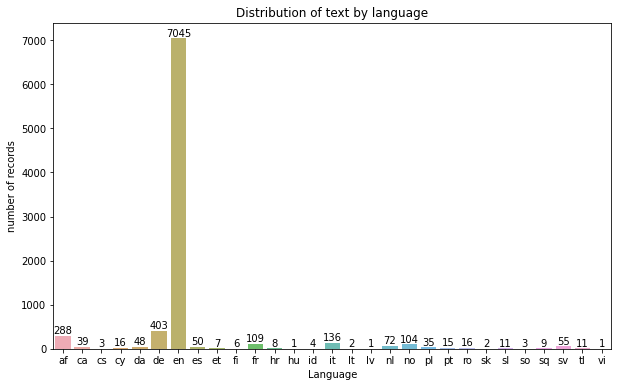

In [25]:
x = clean_data["language"].value_counts()
x=x.sort_index()
plt.figure(figsize=(10,6))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Distribution of text by language")
plt.ylabel('number of records')
plt.xlabel('Language')
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show();

We can see that most of the tickets are in english, followed by tickets in German language. We need to translate these into english.

In [26]:
german_data = pd.read_csv("/content/drive/MyDrive/Capstone/german.csv")
#german_data = pd.read_csv('german.csv')

In [27]:
german_data

German English
0              ich       I
1              sie     you
2              das     the
3              ist      is
4               du     you
...            ...     ...
10392  vereinigung   Union
10393  mittelpunkt   Focus
10394         page    page
10395     andeuten   imply
10396       helene  helene

[10397 rows x 2 columns]

In [28]:
german_dictionary = german_data.to_dict(orient='records')


In [29]:

def translate_function(text):
    translated_text = []
    text_split = text.split()
    for text in text_split:
        word_found = False
        for item in range(len(german_dictionary)):
            if text == german_dictionary[item]["German"]:
                translated_text.append(german_dictionary[item]["English"])
                word_found = True
        if word_found == False:
            translated_text.append(text)
    translate = ' '.join([word for word in translated_text])        
    return translate

clean_data["Translated Text"] = clean_data["Clean_Description"].apply(translate_function)

In [30]:
clean_data["Translated Text"].iloc[0:4]

0    verified user details employee and Manager Sur...
1    hello team my meetings skype meetings etc are ...
2      Hi cannot log on to vpn best cant log in to vpn
3    unable to access hr tool page unable to access...
Name: Translated Text, dtype: object

In [31]:
clean_data["Clean_Description"].iloc[0:4]

0    verified user details employee and manager nam...
1    hello team my meetings skype meetings etc are ...
2      hi cannot log on to vpn best cant log in to vpn
3    unable to access hr tool page unable to access...
Name: Clean_Description, dtype: object

In [32]:
clean_data.tail(10)

Caller  ...                                    Translated Text
8490  mpihysnw wrctgoan  ...  please contact ed pasgryowski pasgryo about hi...
8491  jxgobwrm qkugdipo  ...  i need vpn for my new Laptop Surname llv kneth...
8492  tmopbken ibzougsd  ...  hr tool etime option distress visitble hr tool...
8493  ipwjorsc uboapexr  ...  i at the sorry have another two accounts did n...
8494  cpmaidhj elbaqmtp  ...  tablet needs reimaged due to multiple issues w...
8495  avglmrts vhqmtiua  ...  good afternoon at the distress receiving the e...
8496  rbozivdq gmlhrtvp  ...  telephony software issue telephony software issue
8497  oybwdsgx oxyhwrfz  ...  vip windows password reset for tifpdchb pedxru...
8498  ufawcgob aowhxjky  ...  i at the unable to access the machine utilitie...
8499  kqvbrspl jyzoklfx  ...  at more pc to let themselves various prgramdnt...

[10 rows x 6 columns]

In [33]:
!pip install goslate

  Created wheel for goslate: filename=goslate-1.5.1-cp36-none-any.whl size=11550 sha256=8c7b364a9a86eeeaa8d6ab6daca600dfb410419956d658271eb931d2612daac6
  Stored in directory: /root/.cache/pip/wheels/4f/7f/28/6f52271012a7649b54b1a7adaae329b4246bbbf9d1e4f6e51a
Successfully built goslate


In [34]:
# Define and construct the service urls
domains = ['.com','.com.au','.com.ar','.co.kr','.co.in','.co.jp','.at','.de','.ru','.ch','.fr','.es','.ae']
urls = ['http://translate.google' + domain for domain in domains]

In [35]:
from goslate import Goslate # Provided by Google
import random

# List of column data to consider for translation
trans_cols = ['Clean_Description']

for idx in range(clean_data.shape[0]):
    # Instantiate Goslate class in each iteration
    gs = Goslate(service_urls=random.choice(urls))
    row_iter = gs.translate(clean_data.loc[idx, trans_cols].tolist(), 
                            target_language='en', 
                            source_language='auto')
    clean_data.loc[idx, trans_cols] = list(row_iter)
    time.sleep(30)
    
clean_data.tail()

HTTPError: ignored

In [37]:
# Serialize the translated dataset
clean_data.to_csv('translated_data.csv', index=False, encoding='utf_8_sig')
with open('translated_data.pkl','wb') as f:
    pickle.dump(clean_data, f, pickle.HIGHEST_PROTOCOL)

In [38]:
# Load the translated pickle file 
with open('translated_data.pkl','rb') as f:
    clean_data = pickle.load(f)

### Univariate visualization
Single-variable or univariate visualization is the simplest type of visualization which consists of observations on only a single characteristic or attribute. Univariate visualization includes histogram, bar plots and line charts.

#### The distribution of Assignment groups
Plots how the assignments groups are scattered across the dataset. The bar chart, histogram and pie chart tells the frequency of any ticket assigned to any group OR the tickets count for each group.

In [61]:
init_notebook_mode()
cf.go_offline()

# Assignment group distribution
print('\033[1mTotal assignment groups:\033[0m', clean_data['Assignment group'].nunique())

# Histogram
clean_data['Assignment group'].iplot(
    kind='hist',
    xTitle='Assignment Group',
    yTitle='count',
    title='Assignment Group Distribution- Histogram (Fig-1)')

# Pie chart
assgn_grp = pd.DataFrame(clean_data.groupby('Assignment group').size(),columns = ['Count']).reset_index()
assgn_grp.iplot(
    kind='pie', 
    labels='Assignment group', 
    values='Count', 
    title='Assignment Group Distribution- Pie Chart (Fig-2)', 
    hoverinfo="label+percent+name", hole=0.25)

# Bar plot
clean_data['Assignment group'].iplot(
    kind='bar',
    yTitle='Assignment Group',
    xTitle='Record #',
    colorscale='-plotly',
    title='Assignment Group Distribution- Bar Chart (Fig-3)')

Total assignment groups: 51


### Lets visualize the percentage of incidents per assignment group

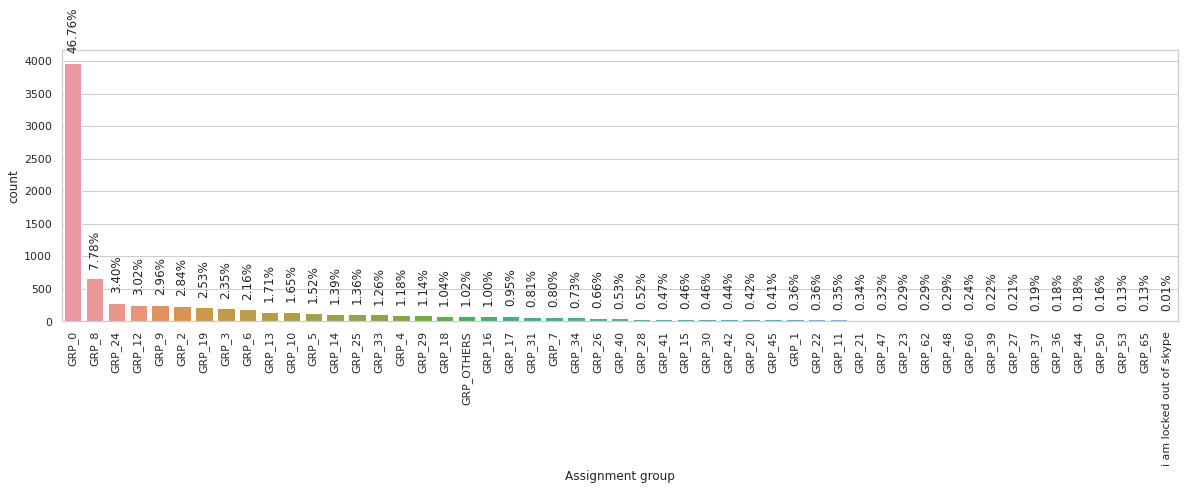

In [40]:
# Plot to visualize the percentage data distribution across different groups
sns.set(style="whitegrid")
plt.figure(figsize=(20,5))
ax = sns.countplot(x="Assignment group", data=clean_data, order=clean_data["Assignment group"].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
for p in ax.patches:
  ax.annotate(str(format(p.get_height()/len(clean_data.index)*100, '.2f')+"%"), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'bottom', rotation=90, xytext = (0, 10), textcoords = 'offset points')

In [41]:
top_20 = clean_data['Assignment group'].value_counts().nlargest(20).reset_index()

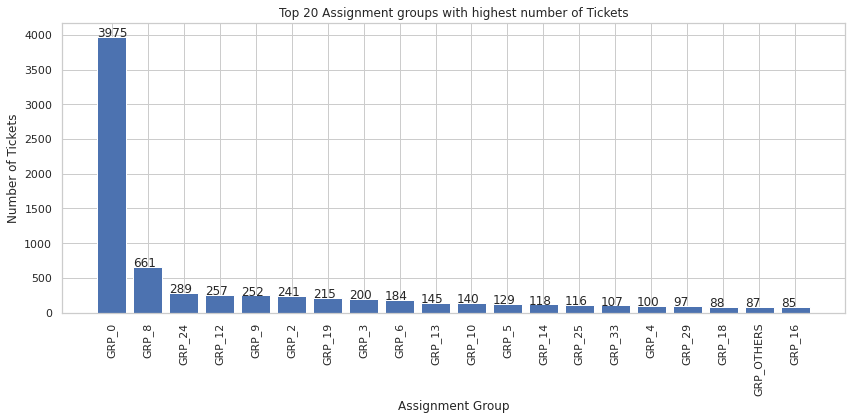

In [42]:
plt.figure(figsize=(12,6))
bars = plt.bar(top_20['index'],top_20['Assignment group'])
plt.title('Top 20 Assignment groups with highest number of Tickets')
plt.xlabel('Assignment Group')
plt.xticks(rotation=90)
plt.ylabel('Number of Tickets')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval + .005, yval)
plt.tight_layout()
plt.show()

In [43]:
bottom_20 = clean_data['Assignment group'].value_counts().nsmallest(20).reset_index()

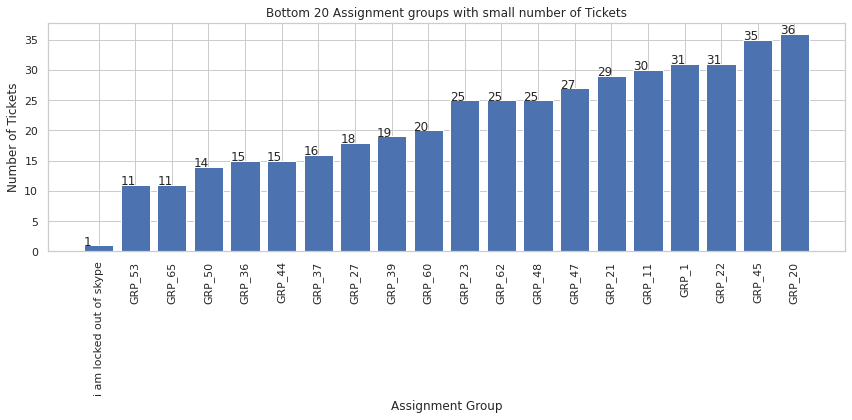

In [44]:
plt.figure(figsize=(12,6))
bars = plt.bar(bottom_20['index'],bottom_20['Assignment group'])
plt.title('Bottom 20 Assignment groups with small number of Tickets')
plt.xlabel('Assignment Group')
plt.xticks(rotation=90)
plt.ylabel('Number of Tickets')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval + .005, yval)
plt.tight_layout()
plt.show()

#### The distribution of Callers
Plots how the callers are associated with tickets and what are the assignment groups they most frequently raise tickets for.

In [45]:
# Find out top 10 callers in terms of frequency of raising tickets in the entire dataset
print('\033[1mTotal caller count:\033[0m', clean_data['Caller'].nunique())
df = pd.DataFrame(clean_data.groupby(['Caller']).size().nlargest(10), columns=['Count']).reset_index()
df.iplot(kind='pie',
         labels='Caller', 
         values='Count', 
         title='Top 10 caller- Pie Chart (Fig-7)',
         colorscale='-spectral',
         pull=[0,0,0,0,0.05,0.1,0.15,0.2,0.25,0.3])

Total caller count: 2951


In [46]:
# Top 5 callers in each assignment group
top_n = 5
s = clean_data['Caller'].groupby(clean_data['Assignment group']).value_counts()
caller_grp = pd.DataFrame(s.groupby(level=0).nlargest(top_n).reset_index(level=0, drop=True))
caller_grp.head(15)

Caller
Assignment group Caller                   
GRP_0            fumkcsji sarmtlhy     132
                 rbozivdq gmlhrtvp      86
                 olckhmvx pcqobjnd      54
                 efbwiadp dicafxhv      45
                 mfeyouli ndobtzpw      13
GRP_1            bpctwhsn kzqsbmtp       6
                 jloygrwh acvztedi       4
                 jyoqwxhz clhxsoqy       3
                 spxqmiry zpwgoqju       3
                 kbnfxpsy gehxzayq       2
GRP_10           bpctwhsn kzqsbmtp      60
                 ihfkwzjd erbxoyqk       6
                 dizquolf hlykecxa       5
                 gnasmtvx cwxtsvkm       3
                 hlrmufzx qcdzierm       3

In [47]:
# Check if any caller appears to raise ticket for multiple groups
mul_caller = caller_grp[caller_grp.Caller.duplicated()]
uni_mul_caller = [idx[1] for idx in mul_caller.index[mul_caller.Caller.unique()]]
print(f'\033[1mFollowing {len(uni_mul_caller)} callers happen to raise tickets for multiple groups:\033[0m\n')
print(uni_mul_caller)

Following 15 callers happen to raise tickets for multiple groups:

['hlrmufzx qcdzierm', 'fbgetczn jlsvxura', 'gnasmtvx cwxtsvkm', 'ihfkwzjd erbxoyqk', 'tqfnalpj qyoscnge', 'fmqubnvs kcxpeyiv', 'tghrloks jbgcvlmf', 'jwqyxbzs adpvilqu', 'nuhfwplj ojcwxser', 'oldrctiu bxurpsyi', 'vlymsnej whlqxcst', 'dkmcfreg anwmfvlg', 'bpctwhsn kzqsbmtp', 'spxqmiry zpwgoqju', 'obanjrhg rnafleys']


#### The distribution of description lengths
Plots the variation of length and word count of new description attribute

In [48]:
clean_data.insert(1, 'desc_len', clean_data['Clean_Description'].astype(str).apply(len))
clean_data.insert(5, 'desc_word_count', clean_data['Clean_Description'].apply(lambda x: len(str(x).split())))
clean_data.head()

Caller  ...                                    Translated Text
0  spxjnwir pjlcoqds  ...  verified user details employee and Manager Sur...
1  hmjdrvpb komuaywn  ...  hello team my meetings skype meetings etc are ...
2  eylqgodm ybqkwiam  ...    Hi cannot log on to vpn best cant log in to vpn
3  xbkucsvz gcpydteq  ...  unable to access hr tool page unable to access...
4  owlgqjme qhcozdfx  ...                            skype error skype error

[5 rows x 8 columns]

In [49]:
# Description text length
clean_data['desc_len'].iplot(
    kind='bar',
    xTitle='text length',
    yTitle='count',
    colorscale='-ylgn',
    title='Description Text Length Distribution (Fig-11)')

# Description word count
clean_data['desc_word_count'].iplot(
    kind='bar',
    xTitle='word count',
    linecolor='black',
    yTitle='count',
    colorscale='-bupu',
    title='Description Word Count Distribution (Fig-12)')

### N-Grams
N-gram is a contiguous sequence of N items from a given sample of text or speech, in the fields of computational linguistics and probability. The items can be phonemes, syllables, letters, words or base pairs according to the application. N-grams are used to describe the number of words used as observation points, e.g., unigram means singly-worded, bigram means 2-worded phrase, and trigram means 3-worded phrase. 

We'll be using scikit-learn’s CountVectorizer function to derive n-grams and compare them before and after removing stop words. Stop words are a set of commonly used words in any language. We'll be using english corpus stopwords and extend it to include some business specific common words considered to be stop words in our case.

In [50]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer

# Extend the English Stop Wordss
STOP_WORDS = STOPWORDS.union({'yes','na','hi',
                              'receive','hello',
                              'regards','thanks',
                              'from','greeting',
                              'forward','reply',
                              'will','please',
                              'see','help','able'})

# Generic function to derive top N n-grams from the corpus
def get_top_n_ngrams(corpus, top_n=None, ngram_range=(1,1), stopwords=None):
    vec = CountVectorizer(ngram_range=ngram_range, 
                          stop_words=stopwords).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:top_n]

### Top Unigrams

In [51]:
# Top 50 Unigrams before removing stop words
top_n = 50
ngram_range = (1,1)
uni_grams = get_top_n_ngrams(clean_data.Clean_Description, top_n, ngram_range)

df = pd.DataFrame(uni_grams, columns = ['Clean_Description' , 'count'])
df.groupby('Clean_Description').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', 
    yTitle='Count', 
    linecolor='black', 
    colorscale='piyg',
    title=f'Top {top_n} Unigrams in Clean_Description')

# Top 50 Unigrams after removing stop words
uni_grams_sw = get_top_n_ngrams(clean_data.Clean_Description, top_n, ngram_range, stopwords=STOP_WORDS)

df = pd.DataFrame(uni_grams_sw, columns = ['Clean_Description' , 'count'])
df.groupby('Clean_Description').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', 
    yTitle='Count', 
    linecolor='black',
    colorscale='-piyg',
    title=f'Top {top_n} Unigrams in Clean_Description without stop words')

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.



### Top Bigrams

In [52]:
# Top 50 Bigrams before removing stop words
top_n = 50
ngram_range = (2,2)
bi_grams = get_top_n_ngrams(clean_data.Clean_Description, top_n, ngram_range)

df = pd.DataFrame(bi_grams, columns = ['Clean_Description' , 'count'])
df.groupby('Clean_Description').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', 
    yTitle='Count', 
    linecolor='black', 
    colorscale='piyg',
    title=f'Top {top_n} Bigrams in Clean_Description')

# Top 50 Bigrams after removing stop words
bi_grams_sw = get_top_n_ngrams(clean_data.Clean_Description, top_n, ngram_range, stopwords=STOP_WORDS)

df = pd.DataFrame(bi_grams_sw, columns = ['Clean_Description' , 'count'])
df.groupby('Clean_Description').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', 
    yTitle='Count', 
    linecolor='black',
    colorscale='-piyg',
    title=f'Top {top_n} Bigrams in Clean_Description without stop words')

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.



### Top Trigrams

In [53]:
# Top 50 Trigrams before removing stop words
top_n = 50
ngram_range = (3,3)
tri_grams = get_top_n_ngrams(clean_data.Clean_Description, top_n, ngram_range)

df = pd.DataFrame(tri_grams, columns = ['Clean_Description' , 'count'])
df.groupby('Clean_Description').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', 
    yTitle='Count', 
    linecolor='black', 
    colorscale='piyg',
    title=f'Top {top_n} Trigrams in Clean_Description')

# Top 50 Trigrams after removing stop words
tri_grams_sw = get_top_n_ngrams(clean_data.Clean_Description, top_n, ngram_range, stopwords=STOP_WORDS)

df = pd.DataFrame(tri_grams_sw, columns = ['Clean_Description' , 'count'])
df.groupby('Clean_Description').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', 
    yTitle='Count', 
    linecolor='black',
    colorscale='-piyg',
    title=f'Top {top_n} Trigrams in Clean_Description without stop words')

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.



### Word Cloud
A word cloud is a collection, or cluster, of words depicted in different sizes. The bigger and bolder the word appears, the more often it’s mentioned within a given text and the more important it is.

Also known as tag clouds or text clouds, these are ideal ways to pull out the most pertinent parts of textual data, often also help business users compare and contrast two different pieces of text to find the wording similarities between the two.

Let's write a generic method to generate Word Clouds for both Short and Long Description columns.

In [54]:
def generate_word_cloud(corpus):
        # Instantiate the wordcloud object
    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    stopwords=STOP_WORDS,
                    # mask=mask,
                    min_font_size = 10).generate(corpus)

    # plot the WordCloud image                        
    plt.figure(figsize = (12, 12), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show()

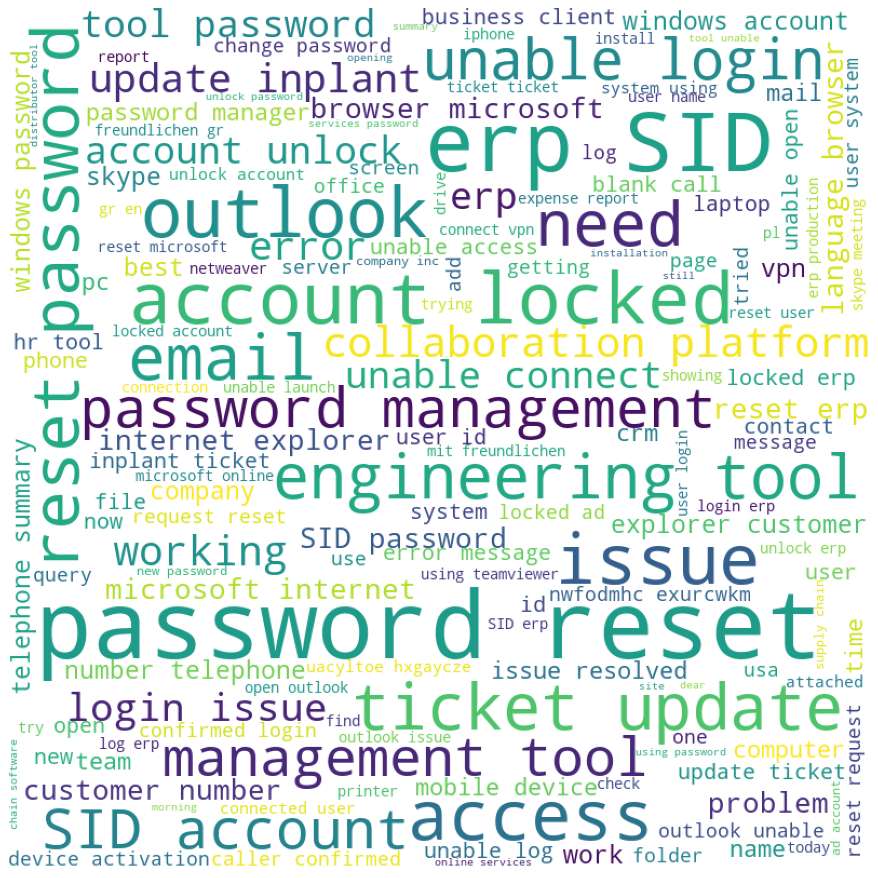

In [55]:
# Word Cloud for all tickets assigned to GRP_0
generate_word_cloud(' '.join(clean_data[clean_data['Assignment group'] == 'GRP_0'].Clean_Description.str.strip()))

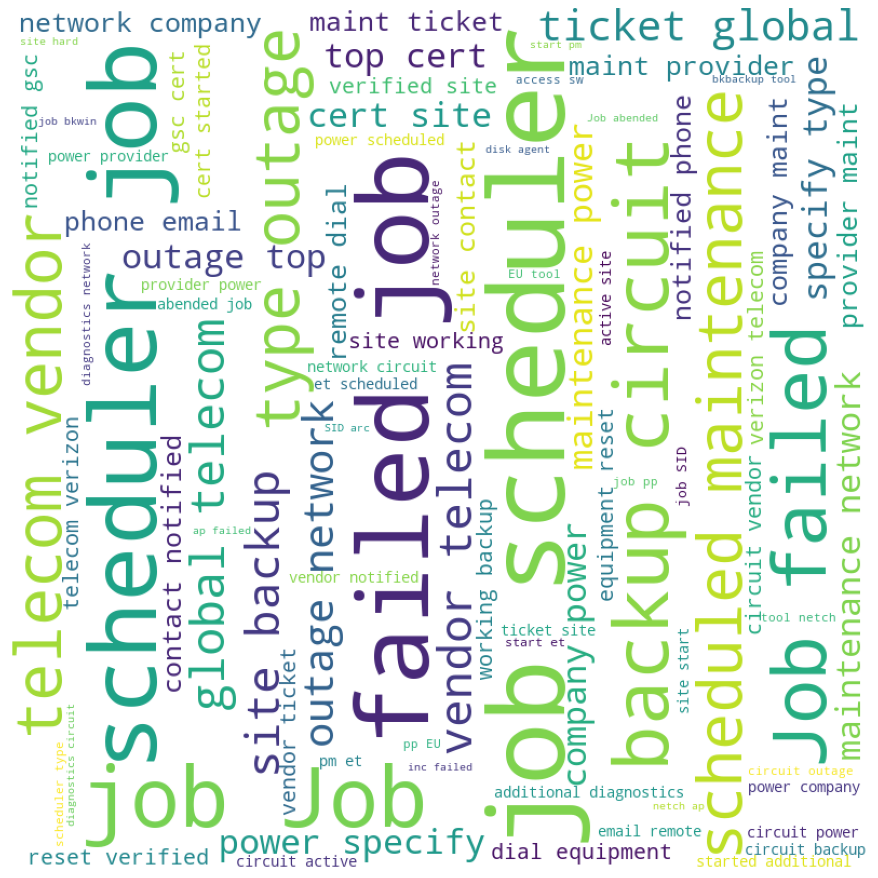

In [56]:
# Word Cloud for all tickets assigned to GRP_8
generate_word_cloud(' '.join(clean_data[clean_data['Assignment group'] == 'GRP_8'].Clean_Description.str.strip()))

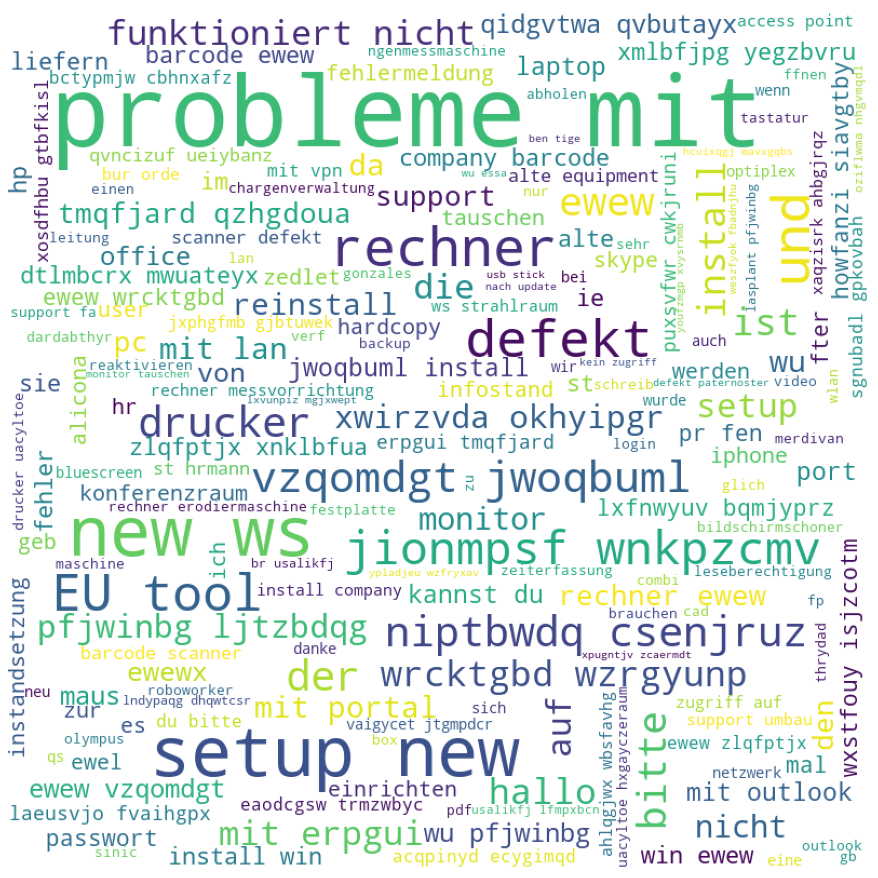

In [57]:
# Word Cloud for all tickets assigned to GRP_24
generate_word_cloud(' '.join(clean_data[clean_data['Assignment group'] == 'GRP_24'].Clean_Description.str.strip()))

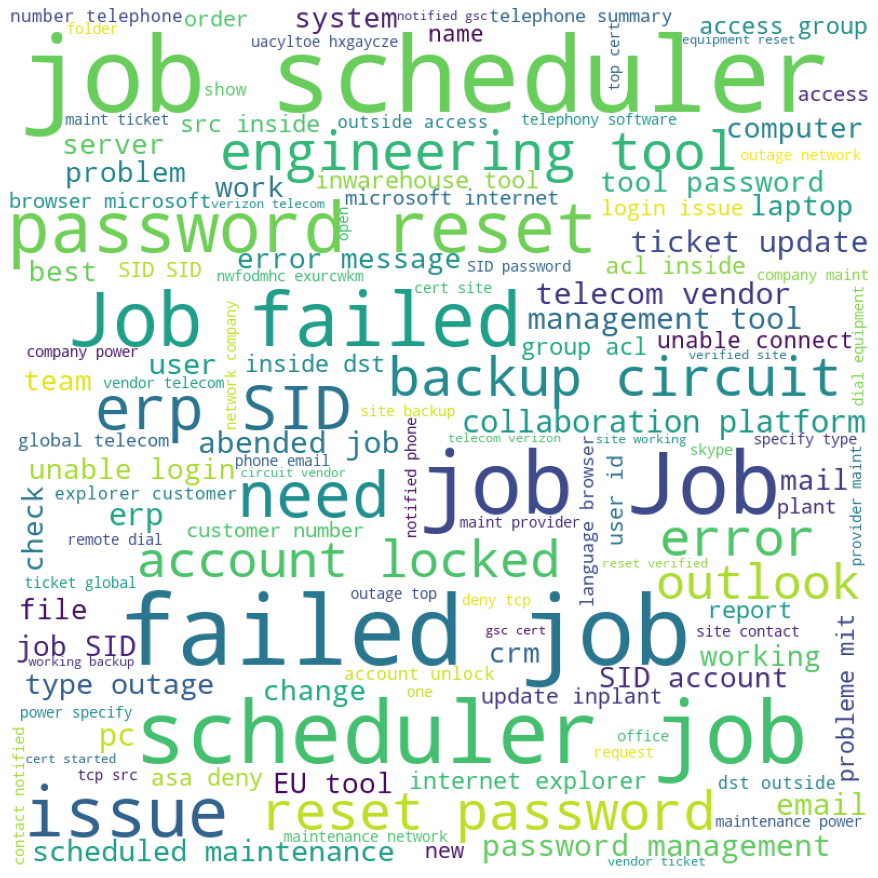

In [58]:
# Generate wordcloud for Clean_Description field
generate_word_cloud(' '.join(clean_data.Clean_Description.str.strip()))